In [14]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from fastprogress.fastprogress import master_bar, progress_bar
%matplotlib inline

from variables import maze_list, Actions

import environment
from environment import maze_game

from tiered_algorithm import words_to_actions, actions_to_words, state_to_actions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment.set_device(device)

print(f'GPU available: {torch.cuda.is_available()}')

GPU available: True


In [2]:
bow = [
    'move',
    'up',
    'left',
    'right',
    'down',
    'one',
    'two',
    'three',
    'blocks',
    '',
    'and',
    'then',
    '1',
    '2',
    '3',
    '4',
    '5',
    'four',
    'five',
    'block',
    'north',
    'south',
    'east',
    'west',
    'go',
    'walk',
    'proceed',
    'step',
    'steps',
    'space',
    'spaces',
]

tensor([[[2]],

        [[4]],

        [[4]],

        [[4]]], device='cuda:0')

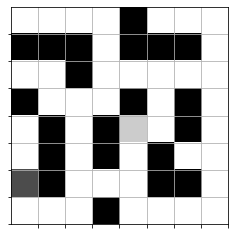

In [3]:
game = maze_game([maze_list[0]])
game.reset()
game.set_target(np.array([4,4]))
game.show()
game.state_to_channels(game.state).shape
# game.valid_actions()
game.best_seq()

In [4]:
def play_game(model, maze, start=None, target=None, max_episodes=100, show_game=False, epsilon=0):
    game = maze_game([maze])
    game.reset()
    sentences = []
    
    if start is not None:
        game.set_position(start)
    if target is not None:
        game.set_target(target)
        
    while game.is_complete():
        game.reset()
        if start is not None:
            game.set_position(start)
        if target is not None:
            game.set_target(target)
        
        
    episode = 0
    envstate = game.get_state()
    while episode < max_episodes:
        episode += 1
        valid_actions = game.valid_actions()
        
        if np.random.rand() < epsilon:
            actions = [random.choice(valid_actions)]
        elif model==None:
            sentence = actions_to_words(state_to_actions(game.state))
            sentences.append(sentence)
            actions = words_to_actions(sentence)
        else:
            a = policy_net(envstate[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
            sentence = [bow[i.item()] for i in a]
            sentences.append(sentence)
            actions = words_to_actions(sentence)
        
        envstate, reward, done, win = game.step(actions)
        
        if done:
            break
    
    if show_game: game.show()
    
    return win, episode, sentences

(True,
 4,
 [['proceed', '1', 'block', 'south'],
  ['go', '2', 'spaces', 'left'],
  ['proceed', 'two', 'blocks', 'south'],
  ['go', '1', 'step', 'west']])

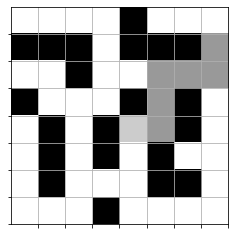

In [5]:
play_game(None, maze_list[0], show_game=True, target=np.array([4,4]))

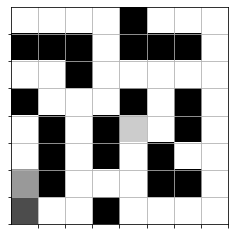

In [6]:
game.step(state_to_actions(game.state, limit_n=4))
game.show()

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [8]:
sequence_length = 4
class DQN_SENDER(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_SENDER, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)
        self.relu2 = nn.ReLU(inplace=False)
        
        convw = 4
        convh = 4
        linear_conv_size = convw * convh * 64
        
        self.gru = nn.GRU(linear_conv_size, linear_conv_size, 2)
        
        self.head = nn.Linear(linear_conv_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        
        # Flatten
        x = x.view(x.shape[0], -1)
        
        x, hn = self.gru(x.repeat(sequence_length,1,1))
        
        return self.head(x.transpose(0,1))

In [9]:
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 3000
TARGET_UPDATE = 10

bleu_hist = [[] for i in range(6)]
wins_hist = [[] for i in range(6)]
rnds_hist = [[] for i in range(6)]


screen_height, screen_width = maze_list[0].shape

n_actions = len(bow)

policy_net = DQN_SENDER(screen_height, screen_width, n_actions).to(device)
target_net = DQN_SENDER(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-5)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, valid_actions=[]):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
    else:
        return torch.tensor(valid_actions, device=device, dtype=torch.long)

episode_durations = []


In [10]:
def optimize_model():
#     return
    optimizer.zero_grad()
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None], dim=0)
    
    state_batch = torch.stack(batch.state, dim=0)
    action_batch = torch.stack(batch.action, dim=0)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_actions = policy_net(state_batch)
    
    state_actions = torch.stack([state_actions[:,i].gather(1, action_batch[:,i]) for i in range(sequence_length)], dim=1)
    state_action_values = state_actions.sum(dim=1)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(2)[0].sum(dim=1).detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss
optimize_model()

In [12]:
s_ref = []
m = maze_list
mb = progress_bar(range(10000))
for i in mb:
    maze_num = np.random.randint(0, len(m))
    win,steps,sentences = play_game(None, m[maze_num], epsilon=0.01, target=np.array([4,4]))
    for s in sentences:
        if s not in s_ref:
            s_ref.append(s)
len(s_ref)

2

In [16]:
from nltk.translate.bleu_score import sentence_bleu

def calc_bleu(network, maze_num=0, N=5000):
    bleu_total = 0
    wins_total = 0
    bleu_scores = []
    rnds_scores = []
    num = 0
    for i in range(N):
        win,steps,ss = play_game(network, maze_list[maze_num], epsilon=0.03, target=np.array([4,4]))
        num += len(ss)
        rnds_scores.append(len(ss))
        for s in ss:
            bleu_scores.append(sentence_bleu(s_ref, s, weights=(0.5,0.5)))
        if win: wins_total += 1
        if num > N:
            break
    return [np.mean(bleu_scores), st.t.interval(0.95, len(bleu_scores)-1, loc=np.mean(bleu_scores), scale=st.sem(bleu_scores))], wins_total/(i+1), [np.mean(rnds_scores), st.t.interval(0.95, len(rnds_scores)-1, loc=np.mean(rnds_scores), scale=st.sem(rnds_scores))]

calc_bleu(policy_net, N=2000)

([0.0, (nan, nan)],
 0.0,
 [95.66666666666667, (94.23244909002958, 97.10088424330377)])

In [29]:
tester = maze_game([maze_list[0]])
tester.reset()
tester.set_target(np.array([4,4]))
tester.set_position(np.array([2,3]))
ax = policy_net(tester.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
se = [bow[i.item()] for i in ax]
axs = words_to_actions(se)
print(f"Episode {0}: '{' '.join(se)}', {axs}")

Episode 0: 'south south south south', []


In [ ]:
# import pickle
# save_file='2020_10_08_sender'
# save_skip=5000
test_skip = 250
num_episodes = 5000
mb = progress_bar(range(num_episodes))
p_skip = 250

env = maze_game(maze_list)

w_hist = []
r_hist = []

# for i_episode in mb:
for i_episode in mb:
    # Initialize the environment and state
    env.reset()
    env.set_target(np.array([4,4]))
    while env.is_complete():
        env.reset()
        env.set_target(np.array([4,4]))

    last_state = env.get_state()
    state = env.get_state()
    loss = []
    for t in count():
        # Select and perform an action
        s = actions_to_words(state_to_actions(env.state))
        valid_actions = [[[bow.index(i)]] for i in s]

        action = select_action(state, valid_actions=valid_actions)
    
        sentence = [bow[i.item()] for i in action]
        
        r_mod = (sequence_length - len(set(sentence)))*-0.01

        actions = words_to_actions(sentence)
        if len(actions) == 0:
            actions = [Actions.NONE]
            
        action = action.view(sequence_length,1)

        _, reward, done, win = env.step(actions)

        reward += r_mod
    
        reward = torch.tensor([reward], device=device)
    
        r_hist += [reward.item()]
        
        if not done:
            next_state = env.get_state()
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss += [optimize_model()]

        if done:
            w_hist.append(win)
            break
    
    if (i_episode+1)%test_skip == 0:
        for i in range(6):
            bleu,wins,rnds = calc_bleu(policy_net, N=5000, maze_num=i)
            bleu_hist[i].append(bleu)
            wins_hist[i].append(wins)
            rnds_hist[i].append(rnds)
            print(f'[Map {i}] bleu: {bleu[0]:.3f}, winrate: {wins:.3f}')
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

#     if (i_episode+1)%save_skip==0:
#         with open(f'models/{save_file}_policy.pkl', 'wb') as f:
#             pickle.dump(policy_net, f)
#         with open(f'models/{save_file}_target.pkl', 'wb') as f:
#             pickle.dump(target_net, f)
        
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
    if (i_episode+1)%p_skip == 0:
        print(f"Episode: {i_episode:5d}/{num_episodes-1} | Rounds: {env.rounds:3d} | Steps: {env.steps:3d} | Wins: {sum(w_hist):5d} | Epsilon: {eps_threshold:.3f} | Avg Episode Reward: {f'{np.mean(r_hist[-(t+1):]):.4f}':>7s} | Avg Reward: {f'{np.mean(r_hist[-200:]):.4f}':>7s} | Total Winrate: {f'{sum(w_hist)/(i_episode+1)*100:>3.1f}':>5s}% | Recent Winrate: {f'{sum(w_hist[-p_skip:])/(p_skip)*100:>3.1f}':>5s}%")
        
#         tester = maze_game([maze_list[0]])
#         tester.reset()
#         tester.set_target(np.array([4,4]))
#         tester.set_position(np.array([2,3]))
#         ax = policy_net(tester.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
#         se = [bow[i.item()] for i in ax]
#         axs = words_to_actions(se)
#         print(f"Episode {i_episode}: '{' '.join(se)}', {axs}")
        
        

Sentence: '5 5 5 5'
[<Actions.NONE: 4>]


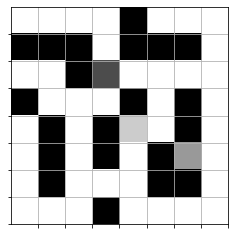

In [17]:
env = maze_game([maze_list[0]])
env.reset()
env.set_target(np.array([4,4]))
env.set_position(np.array([2,3]))
env.show()
action = policy_net(env.get_state()[None]).max(2)[1].view(1, sequence_length, 1, 1)[0]
sentence = [bow[i.item()] for i in action]
# actions
print(f"Sentence: '{' '.join(sentence)}'")
actions = words_to_actions(sentence)
if len(actions) == 0:
    actions = [Actions.NONE]
env.step(actions)
env.show()
print(actions)

In [24]:
mb = progress_bar(range(10000))
# m = [maze_list[0]]
m = maze_list
w_hist = [[] for i in range(len(m))]
s_hist = [[] for i in range(len(m))]
for i in mb:
    maze_num = np.random.randint(0, len(m))
    win,steps,s = play_game(policy_net, m[maze_num], epsilon=0.01, target=np.array([4,4]))
    w_hist[maze_num] = np.append(w_hist[maze_num], win)
    s_hist[maze_num] = np.append(s_hist[maze_num], steps)
    
print(f"Total Win Rate: {np.mean(np.concatenate(np.array(w_hist)))*100:.2f}%, Avg Steps: {np.mean(np.concatenate(np.array(s_hist)))}")
for i,j in enumerate(w_hist):
    print(f"Maze {i}: {f'{np.mean(j)*100:.2f}':>6s}%, {np.mean(s_hist[i]):.2f} steps")

Total Win Rate: 99.43%, Avg Steps: 4.333
Maze 0: 100.00%, 4.08 steps
Maze 1:  97.82%, 7.80 steps
Maze 2: 100.00%, 2.67 steps
Maze 3:  98.73%, 6.25 steps
Maze 4: 100.00%, 2.68 steps
Maze 5: 100.00%, 2.58 steps


<ipython-input-24-b6b8e6109b68>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(f"Total Win Rate: {np.mean(np.concatenate(np.array(w_hist)))*100:.2f}%, Avg Steps: {np.mean(np.concatenate(np.array(s_hist)))}")


In [134]:
import pickle
with open('models/sender_policy.pkl', 'wb') as f:
    pickle.dump(policy_net, f)
with open('models/sender_target.pkl', 'wb') as f:
    pickle.dump(target_net, f)

In [40]:
import pickle
with open('models/sender_policy.pkl', 'rb') as f:
    policy_net = pickle.load(f)
with open('models/sender_target.pkl', 'rb') as f:
    target_net = pickle.load(f)

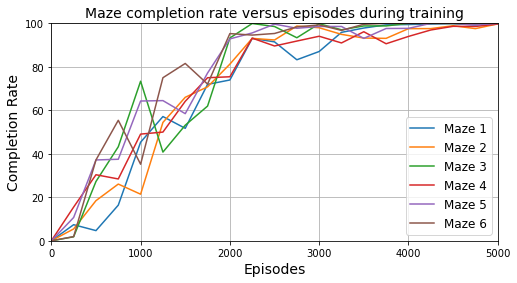

In [20]:
# ax = plt.figure()
f = plt.figure(figsize=(8,4))
for data in wins_hist:
    plt.plot(np.arange(0,len(data)*test_skip+1,test_skip), np.asarray([0] + data)*100)
    
plt.xlim([0,len(data)*test_skip])
plt.ylim([0,100])
plt.grid()
plt.legend([f'Maze {i+1}' for i in range(6)], loc='lower right', fontsize=12)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Completion Rate', fontsize=14)
plt.title('Maze completion rate versus episodes during training', fontsize=14)
plt.show()
# f.savefig("win_rate.pdf", bbox_inches='tight')

C:\Users\kelof\.conda\envs\py38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-0.008382076778764791
-0.00843287254079339
-0.009044465106437194
-0.008932810884644482
-0.012968838462817933
-0.007645910765349928


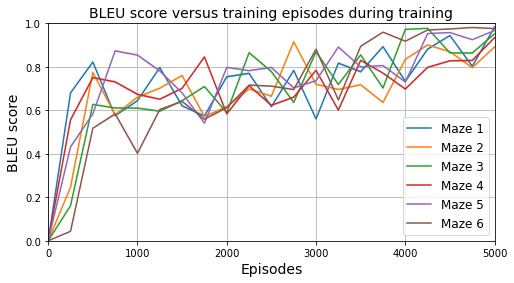

In [30]:
# ax = plt.figure()
f = plt.figure(figsize=(8,4))
x = np.arange(0,len(np.asarray(bleu_hist)[0,:,0])*test_skip+1,test_skip)
for data in np.asarray(bleu_hist):
    plt.plot(x, np.concatenate((np.array([0.0]), data[:,0])))
    y1 = []
    y2 = []
    for y in data[:,1]:
        y1.append(y[0])
        y2.append(y[1])
    plt.fill_between(x, [100]+y1, [100]+y2, alpha=0.2)
    
plt.xlim([0,len(data)*test_skip])
plt.legend([f'Maze {i+1}' for i in range(6)], loc='lower right', fontsize=12)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('BLEU score', fontsize=14)
plt.title('BLEU score versus training episodes during training', fontsize=14)
plt.grid()
plt.ylim([0,1])
# f.savefig("bleu_score.pdf", bbox_inches='tight')

C:\Users\kelof\.conda\envs\py38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


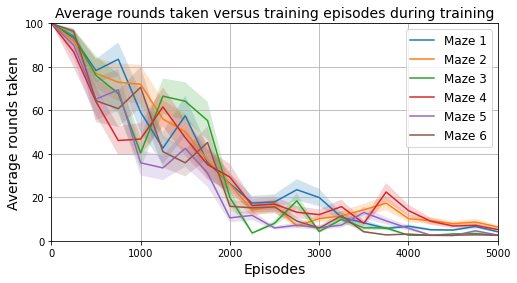

In [23]:
# ax = plt.figure()
f = plt.figure(figsize=(8,4))
x = np.arange(0,len(data[:,0])*test_skip+1,test_skip)
for data in np.asarray(rnds_hist):
    plt.plot(x, np.concatenate((np.array([100.0]), data[:,0])))
    y1 = []
    y2 = []
    for y in data[:,1]:
        y1.append(y[0])
        y2.append(y[1])
    plt.fill_between(x, [100]+y1, [100]+y2, alpha=0.2)
    
plt.xlim([0,len(data)*test_skip])
plt.legend([f'Maze {i+1}' for i in range(6)], loc='upper right', fontsize=12)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Average rounds taken', fontsize=14)
plt.title('Average rounds taken versus training episodes during training', fontsize=14)
plt.grid()
plt.ylim([0,100])
# f.savefig("avg_rounds.pdf", bbox_inches='tight')

In [27]:
data = {'test_skip': test_skip, 'wins': wins_hist, 'bleu': bleu_hist, 'rounds': rnds_hist}

In [28]:
import json

with open('results.json', 'w') as outfile:
    json.dump(data, outfile)

In [2]:
import json

with open('result.json') as json_file:
    data = json.load(json_file)

In [39]:
# Random sequence generation
mb = progress_bar(range(2000))
total2 = 0
for i in mb:
    s = [random.choice(bow) for i in range(4)]
    total2 += sentence_bleu(s_ref, s, weights=(0.5,0.5))
total2/2000

0.18737963368889748